In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, make_scorer, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

Wczytanie wyszczyszonych danych.

In [2]:
df = pd.read_csv("Cleaned_data.csv", sep = ',')

Sprawdzenie, czy wszystkie kolumny mają dane numeryczne.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498623 entries, 0 to 498622
Data columns (total 50 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Country_US                         498623 non-null  int64  
 1   ASN                                498623 non-null  float64
 2   TTL                                498623 non-null  float64
 3   Alexa_Rank                         498623 non-null  float64
 4   subdomain                          498623 non-null  float64
 5   len                                498623 non-null  float64
 6   entropy                            498623 non-null  float64
 7   Domain_Age                         498623 non-null  int64  
 8   tld_com                            498623 non-null  int64  
 9   Name_Server_Count                  498623 non-null  float64
 10  Page_Rank                          498623 non-null  float64
 11  Label                              4986

Sprawdzenie, czy w kolumnach zostały puste wartości.

In [4]:
df.isna().sum().sort_values(ascending=False).head(15)

typos_yandex.ru                      0
IP_Class_Class A                     0
Organization_REDACTED FOR PRIVACY    0
Organization_Domains By Proxy        0
Creation_Year_2015-now               0
Creation_Year_2009-2014              0
Creation_Year_2003-2008              0
Creation_Year_1997-2002              0
Creation_Year_before 1996            0
IP_Class_Invalid IP                  0
IP_Class_Class C                     0
IP_Class_Class B                     0
Label                                0
typos_miitbeian.gov.cn               0
Page_Rank                            0
dtype: int64

In [5]:
df.shape

(498623, 50)

Przed przystąpieniem do uczenia modelu sprawdzamy, czy zmienne między sobą nie są skorelowane.

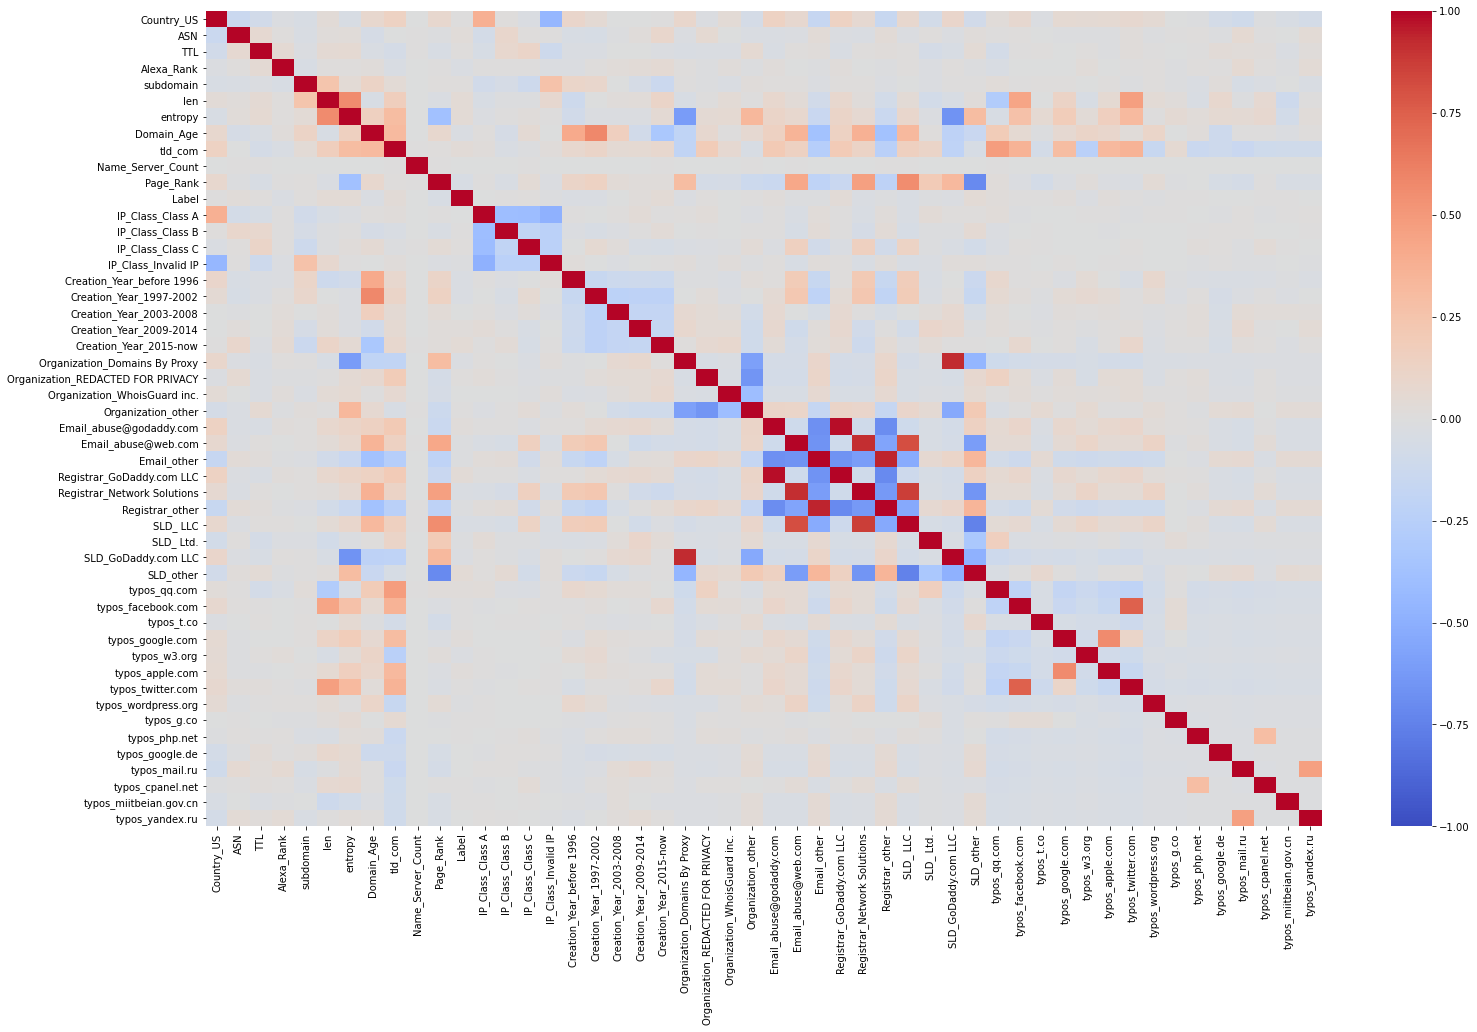

In [6]:
correlation_matrix = df.corr()

plt.figure(figsize=(25, 15))
sns.heatmap(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)

plt.show()  

In [7]:
df.columns

Index(['Country_US', 'ASN', 'TTL', 'Alexa_Rank', 'subdomain', 'len', 'entropy',
       'Domain_Age', 'tld_com', 'Name_Server_Count', 'Page_Rank', 'Label',
       'IP_Class_Class A', 'IP_Class_Class B', 'IP_Class_Class C',
       'IP_Class_Invalid IP', 'Creation_Year_before 1996',
       'Creation_Year_1997-2002', 'Creation_Year_2003-2008',
       'Creation_Year_2009-2014', 'Creation_Year_2015-now',
       'Organization_Domains By Proxy', 'Organization_REDACTED FOR PRIVACY',
       'Organization_WhoisGuard inc.', 'Organization_other',
       'Email_abuse@godaddy.com', 'Email_abuse@web.com', 'Email_other',
       'Registrar_GoDaddy.com LLC', 'Registrar_Network Solutions',
       'Registrar_other', 'SLD_ LLC', 'SLD_ Ltd.', 'SLD_GoDaddy.com LLC',
       'SLD_other', 'typos_qq.com', 'typos_facebook.com', 'typos_t.co',
       'typos_google.com', 'typos_w3.org', 'typos_apple.com',
       'typos_twitter.com', 'typos_wordpress.org', 'typos_g.co',
       'typos_php.net', 'typos_google.de', 'typo

Zwracamy uwagę na czerwone/pomarańczowe i niebieskie kratki. Jeżeli dwie zmienne mają dodatnią/ujemną korelację, to należy usunąć jedną z nich.

In [8]:
df = df.drop([
    'Organization_Domains By Proxy','IP_Class_Class A','Creation_Year_1997-2002','SLD_ LLC','Email_abuse@godaddy.com', 'Email_abuse@web.com','SLD_other', 'Email_other', 'SLD_GoDaddy.com LLC', 'typos_twitter.com', 'typos_apple.com', 'entropy'
], axis = 1)

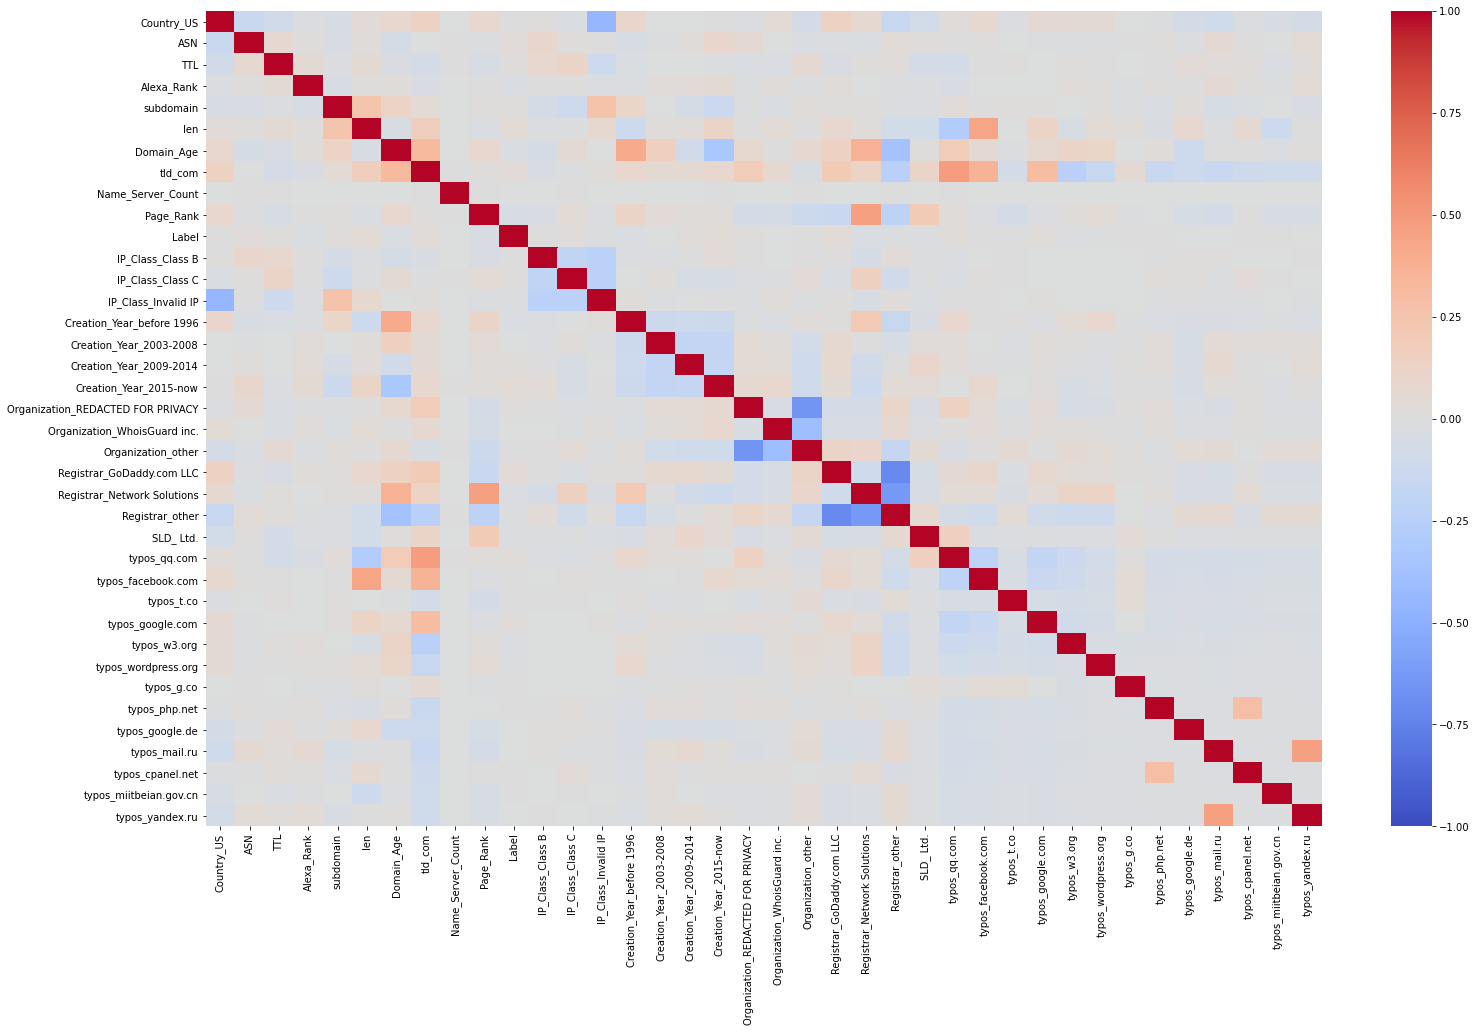

In [9]:
correlation_matrix = df.corr()

plt.figure(figsize=(25, 15))
sns.heatmap(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)

plt.show()

Na mapie korelacji widać również, że kolumna 'Label', czyli zmienna objaśniana nie jest skorelowana z innymi zmiennymi. Możemy się spodziewać, że klasyfikator nie będzie bardzo dokładny.

Zdefiniowanie zmiennej objaśnianej i zmiennych objaśniających.

In [10]:
X = df.drop(columns ='Label') 
y = df['Label']  

Skalowanie zmiennych objaśniających metodą MinMaxScaler(), czyli tak aby wartości były z przedziału 0-1.

In [11]:
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

Używając modelu drzewa decyzyjnego korzystamy z atrybutu feature_importances_ do określenia, które zmienne są najważniejsze w klasyfikacji.

In [12]:
clf = DecisionTreeClassifier()
clf.fit(X_scaled, y)
feature_importance = clf.feature_importances_

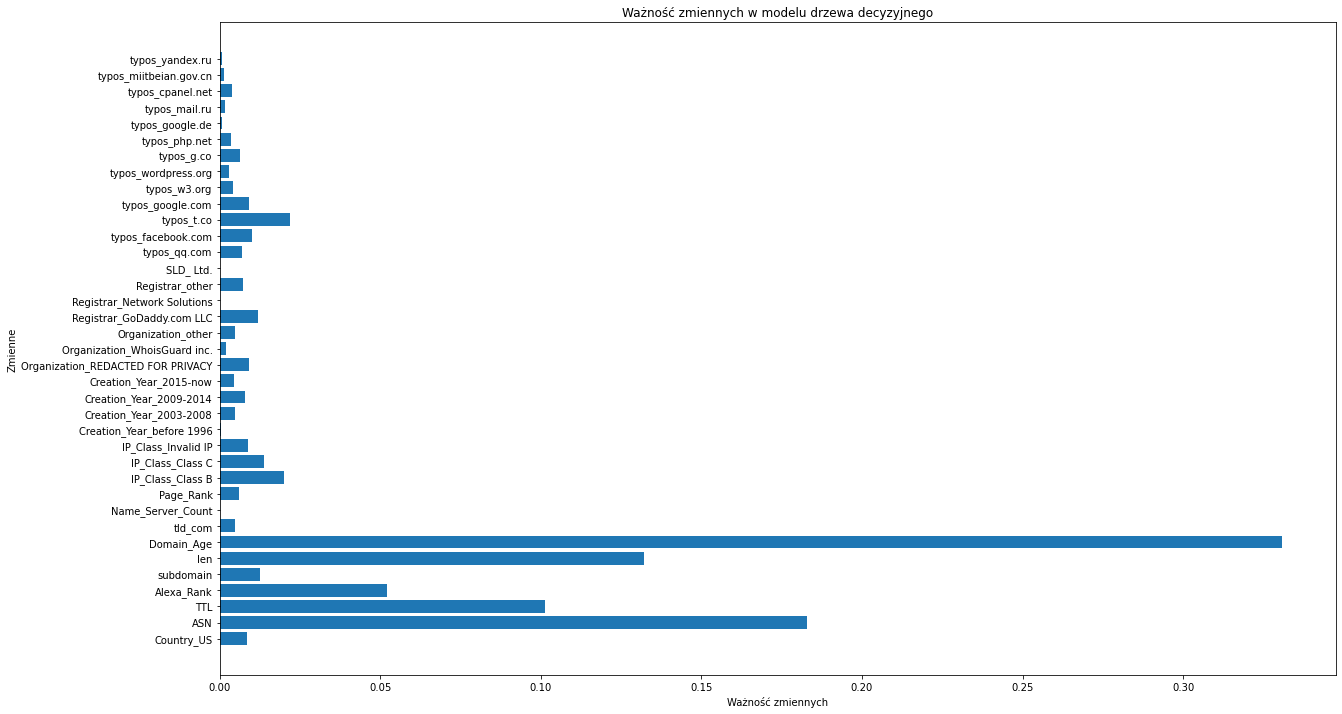

In [13]:
feature_names = X.columns

plt.figure(figsize=(20, 12))
plt.barh(range(len(feature_importance)), feature_importance, align='center')
plt.yticks(range(len(feature_importance)), feature_names)
plt.xlabel('Ważność zmiennych')
plt.ylabel('Zmienne')
plt.title('Ważność zmiennych w modelu drzewa decyzyjnego')
plt.show()

Patrząc na powyższy wykres możemy określić, że najważniejszymi zmiennymi są:
* Domain_Age
* ASN
* len  
Kolumny, które mają wartość 0 usuwamy.

In [14]:
X = X.drop(['Name_Server_Count', 'SLD_ Ltd.', 'typos_yandex.ru',  'Creation_Year_before 1996', 'Registrar_Network Solutions'], axis = 1)
X_scaled = X_scaled.drop(['Name_Server_Count', 'SLD_ Ltd.', 'typos_yandex.ru',  'Creation_Year_before 1996', 'Registrar_Network Solutions'], axis = 1)

In [15]:
X.head(5)

,Country_US,ASN,TTL,Alexa_Rank,subdomain,len,Domain_Age,tld_com,Page_Rank,IP_Class_Class B,...,typos_t.co,typos_google.com,typos_w3.org,typos_wordpress.org,typos_g.co,typos_php.net,typos_google.de,typos_mail.ru,typos_cpanel.net,typos_miitbeian.gov.cn
0,1,15169.000000,46.0,1.0,0.0,7.0,8256,1,-1.0,1,...,0,1,0,0,0,0,0,0,0,0
1,0,35970.123536,299.0,1.0,0.0,7.0,8256,1,-1.0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,35970.123536,38.0,1.0,1.0,10.0,8256,1,-1.0,0,...,0,1,0,0,0,0,0,0,0,0
3,1,15169.000000,299.0,79562.0,1.0,10.0,0,1,-1.0,1,...,0,1,0,0,0,0,0,0,0,0
4,0,35970.123536,96.0,4.0,0.0,9.0,8426,1,-1.0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
X_scaled.head(5)

,Country_US,ASN,TTL,Alexa_Rank,subdomain,len,Domain_Age,tld_com,Page_Rank,IP_Class_Class B,...,typos_t.co,typos_google.com,typos_w3.org,typos_wordpress.org,typos_g.co,typos_php.net,typos_google.de,typos_mail.ru,typos_cpanel.net,typos_miitbeian.gov.cn
0,1.0,0.038082,0.000116,1.831711e-07,0.0,0.042553,0.643492,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.090315,0.000753,1.831711e-07,0.0,0.042553,0.643492,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.090315,0.000096,1.831711e-07,1.0,0.063830,0.643492,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.038082,0.000753,7.286822e-03,1.0,0.063830,0.000000,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.090315,0.000242,4.579278e-07,0.0,0.056738,0.656742,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Podział danych na zbiór treningowy i testowy.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=1)

In [18]:
y_train.value_counts(normalize=True)*100

0    98.984201
1     1.015799
Name: Label, dtype: float64

In [19]:
y_test.value_counts(normalize=True)*100

0    99.050389
1     0.949611
Name: Label, dtype: float64

Skorzystamy z modelu regresji logistycznej. Dążymy do tego aby model przewidywał jak najlepiej domeny niebezpieczne, staramy się zminimalizować liczbę fałszywie bezpiecznych stron przewidzianych przez klasyfikator. Jeżeli model określi fałszywie, że strona jest niebezpieczna, jest to lepszy przypadek niż sklasyfikowanie domeny jako fałszywie bezpieczna. Podobnie jest z klasyfikacją pacjentów na zdrowych i chorych - lepiej jeżeli model sklasyfikuje zdrowego pacjenta jako chorego niż na odwrót.

In [20]:
model1 = LogisticRegression(max_iter=1000)

model1.fit(X_train, y_train)

y_pred1 = model1.predict(X_test)

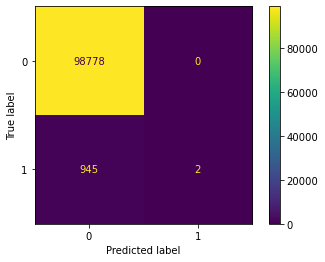

In [21]:
cm = confusion_matrix(y_test,y_pred1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model1.classes_)                           
disp.plot()

In [22]:
print(accuracy_score(y_test,y_pred1))
print(recall_score(y_test,y_pred1))

0.9905239408373026
0.0021119324181626186


Sprawdzając accuracy_score możemy stwierdzić, że model w 99% poprawnie klasyfikuje domeny. Jednak patrząc na macierz błędu możemy zauważyć, że dobrze radzi sobie z klasyfikacją domen bezpiecznych, ale praktycznie nie wychwytuje żadnych domen niebezpieczych i fałszywie klasyfikuje je jako bezpieczne. Może być to spowodowane tym, że 99% rekordów to domeny bezpieczne, zatem z domyślnie ustawionym progiem prawdopodobieństwa w regresji logistycznej równym 0,5 model klasyfikuje źle domeny niebezpieczne. Spróbujemy zmiejszyć próg, tak aby jeżeli jest szansa, że domena jest niebezpieczna, sklasyfikował ją jako niebezpieczną.

In [23]:
y_pred2 = (model1.predict_proba(X_test)[:, 1] >= 0.1).astype(int)

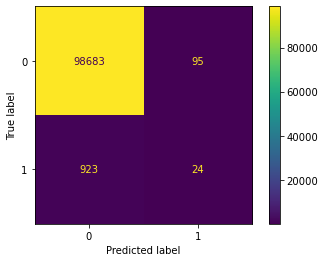

In [24]:
cm = confusion_matrix(y_test,y_pred2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model1.classes_)                           
disp.plot()

In [25]:
print(accuracy_score(y_test,y_pred2))
print(recall_score(y_test,y_pred2))

0.989791927801454
0.025343189017951427


Widzimy, że wartość accuracy lekko spadła, a wzrosła wartość recall do czego dążymy.

Spróbujemy dodać dodatkowy parametr, który w modelu regresji logistycznej przypisuje wagi dla klas. Poszukamy najlepszej wagi dla klasy 1 metodą GridSearchCV.

In [26]:
param_grid = {
    'class_weight': [{0: 1, 1: w} for w in [50, 60, 70, 80, 90, 100]]  
}

model3 = LogisticRegression(max_iter=1000)

grid_search = GridSearchCV(model3, param_grid, scoring = 'f1', cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_params

{'class_weight': {0: 1, 1: 50}}

In [27]:
best_params

{'class_weight': {0: 1, 1: 50}}

In [28]:
model2 = LogisticRegression(class_weight={0: 1, 1: 50}, max_iter=1000)

model2.fit(X_train, y_train)

y_pred3 = (model2.predict_proba(X_test)[:, 1] >= 0.3).astype(int)

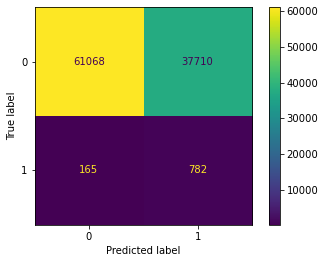

In [29]:
cm = confusion_matrix(y_test,y_pred3)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model1.classes_)                           
disp.plot()

In [30]:
print(accuracy_score(y_test,y_pred3))
print(recall_score(y_test,y_pred3))

0.6202055653045876
0.8257655755015839


Sprawdźmy, czy model nie jest przetrenowany na danych treningowych.

In [31]:
y_train3 = (model2.predict_proba(X_train)[:, 1] >= 0.3).astype(int)

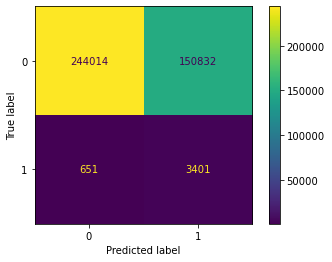

In [32]:
cm = confusion_matrix(y_train,y_train3)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model1.classes_)                           
disp.plot()

In [33]:
print(accuracy_score(y_train,y_train3))
print(recall_score(y_train,y_train3))

0.62024627849726
0.8393385982230998


Model na danych testowych oraz treningowych radzi sobie podobnie, zatem nie jest przetrenowany.

Na tym etapie przy zmniejszaniu progu prawdopodobieństwa oraz zwiększaniu wagi klasy 1 (domena niebezpieczna) czułość modelu rośnie, lecz maleje dokładność, ponieważ model lepiej radzi sobie z klasyfikacją domen niebezpiecznych, jednocześnie częściej myląc się przy rozpoznawaniu domen bezpiecznych. W zależności od potrzeb można dostosowywać parametry.  

* Prawdopodobnie, jeżeli dane byłby dokładniej wyczyszczone, model mógłby być lepszy.
* Patrząc na korelacje praktycznie żadna z kolumn nie była skorelowana ze zmienną objaśnianą, co może być również przyczyną takich wyników klasyfikacji. 
* Można spróbować również innych metod klasyfikacji, mając w pamięci, że zmienne objaśniające są ciągłe jak i binarne, czy kategoryczne. 